# Uni-Mol Molecular Property Prediction

**Licenses**

Copyright (c) DP Technology.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.

**Citations**

Please cite the following papers if you use this notebook:

- Gengmo Zhou, Zhifeng Gao, Qiankun Ding, Hang Zheng, Hongteng Xu, Zhewei Wei, Linfeng Zhang, Guolin Ke. "[Uni-Mol: A Universal 3D Molecular Representation Learning Framework.](https://chemrxiv.org/engage/chemrxiv/article-details/6318b529bada388485bc8361)"
ChemRxiv (2022)

## Data Preparation (SMILES, label to .lmdb)

In [14]:
import os
import lmdb
import pickle
import time
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  
import warnings
warnings.filterwarnings(action='ignore')
from multiprocessing import Pool
import torch
import io 

## Finetuning (based on pretraining)

## Inference

## Read inference results (.pkl to .csv)

In [15]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def get_csv_results(predict_path, csv_path):
    with open(predict_path, 'rb') as f:
        predict = CPU_Unpickler(f).load()
    smi_list, predict_list = [], []
    target_list = []
    for batch in predict:
        sz = batch["bsz"]
        for i in range(sz):
            smi_list.append(batch["smi_name"][i])
            predict_list.append(batch["predict"][i][0].cpu().tolist())
            target_list.append(batch["target"][i][0].cpu().tolist())
    predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list, "target": target_list})
    predict_df = predict_df.groupby("SMILES").mean().reset_index()
    predict_df.to_csv(csv_path,index=False)
    return predict_df


predict_df_list = []
for i in range(0, 10):

    predict_path=f"/scratch/ssd004/datasets/cellxgene/unimol_pred/pred1920/{i}/weights_test.out.pkl"  # replace to your results path
    csv_path=f"/scratch/ssd004/datasets/cellxgene/unimol_pred/pred1920/{i}/pred.csv"
    predict_df = get_csv_results(predict_path, csv_path)
    predict_df_list.append(predict_df)
    
combined_df = pd.concat(predict_df_list)

combined_df.info(), predict_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219798 entries, 0 to 22117
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   SMILES   219798 non-null  object 
 1   predict  219798 non-null  float64
 2   target   219798 non-null  float64
dtypes: float64(2), object(1)
memory usage: 6.7+ MB


(None,
                                               SMILES   predict  target
 0  C#CCCCCCCCCC(=O)N(CCCN1CCCCCC1)C(C(=O)NC(C)(C)... -0.235918    -1.0
 1  C#CCCCCCCCCC(=O)N(CCCN1CCCCCC1)C(C(=O)NC(C)(C)... -0.228527    -1.0
 2  C#CCCCCCCCCC(=O)N(CCCN1CCCCCC1)C(C(=O)NC)C(CCC... -0.265103    -1.0
 3  C#CCCCCCCCCC(=O)N(CCCN1CCCCCC1)C(C(=O)NC12C[C@... -0.258811    -1.0
 4  C#CCCCCCCCCC(=O)N(CCCN1CCCCCC1)C(C(=O)NC1CCCC1... -0.242276    -1.0)

In [16]:
combined_df

,SMILES,predict,target
0,C#CCCCCCCCCC(=O)N(C(C(=O)NC(C)(C)C)C(CCCCCC)CC...,0.161843,-1.0
1,C#CCCCCCCCCC(=O)N(C(C(=O)NC(C)(C)CC(C)(C)C)C(C...,0.153082,-1.0
2,C#CCCCCCCCCC(=O)N(C(C(=O)NC)C(CCCCCC)CCCCCCCC)...,0.168113,-1.0
3,C#CCCCCCCCCC(=O)N(C(C(=O)NC12C[C@H]3C[C@@H](C1...,0.173418,-1.0
4,C#CCCCCCCCCC(=O)N(C(C(=O)NC1CCCC1)C(CCCCCC)CCC...,0.110820,-1.0
...,...,...,...
22113,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,-0.244618,-1.0
22114,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,-0.264859,-1.0
22115,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,-0.271873,-1.0
22116,CCCCCCCCCCOC(=O)CCCCC(=O)N(c1nccs1)C(CCCCCOC(=...,-0.257247,-1.0


In [17]:
combined_df_sort = combined_df.sort_values(by="predict", ascending=False)

In [18]:
# combined_df_sort.to_csv(f"/scratch/ssd004/datasets/cellxgene/unimol_pred/pred1920/combined_df_sort.csv", index=False)
combined_df_sort

,SMILES,predict,target
21488,CCCCCCCCCCCOC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCC...,0.473810,-1.0
12583,CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(C)CCC...,0.471724,-1.0
18077,CCCCCCCCCCCCCCCC(C(=O)NC1CCCCC1)N(CCCN(C)CCCN)...,0.471103,-1.0
13978,CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CC...,0.469105,-1.0
13990,CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CC...,0.467707,-1.0
...,...,...,...
17037,CCCCCCCCCCCCCC(=O)N(CC1CCN(O)CC1)C(CCCCCOC(=O)...,-0.467108,-1.0
3485,CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CC1CCN(O)CC1)C(C...,-0.467884,-1.0
11613,CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NCS(=O)(=O)...,-0.469460,-1.0
14466,CCCCCCCCCCC(=O)N(CC1CCN(O)CC1)C(CCCCCOC(=O)C(C...,-0.470703,-1.0


Top 30 predicted smiles: 


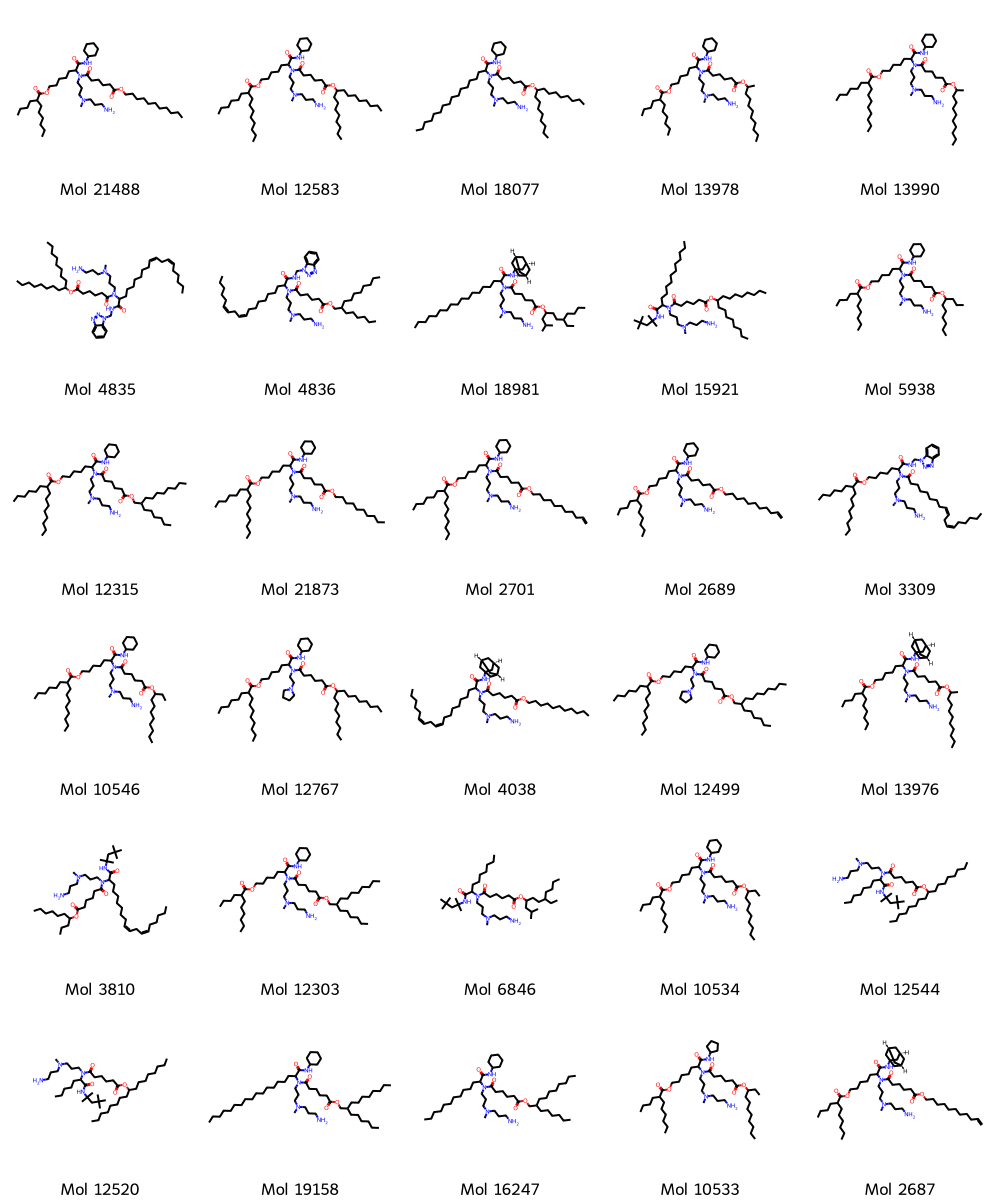

['CCCCCCCCCCCOC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCC)CCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCCCCCCCC(C(=O)NC1CCCCC1)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC'
 'CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCC)CCCCCC)C(=O)NC1CCCCC1'
 'CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1'
 'CCCCC/C=C\\C/C=C\\CCCCCCCC(C(=O)NCn1nnc2ccccc21)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC'
 'CCCCC/C=C\\C/C=C\\CCCCCCCC(C(=O)NCn1nnc2ccccc21)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OCC(CCCCCC)CCCCCCCC'
 'CCCCCCCCCCCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCC(CC)CCCC)CC(C)C'
 'CCCCCCCCCCCC(C(=O)NC(C)(C)CC(C)(C)C)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC'
 'CCCCCCC(CCC)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCC)CCCCCC)C(=O)NC1CCCCC1']


In [19]:
# rank the predict_df by predict value

# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 30 predicted smiles: ")
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in combined_df_sort["SMILES"].values[:30]], molsPerRow=5, legends=[f"Mol {id}" for id in combined_df_sort["SMILES"].index[:30]])
display(img)
print(combined_df_sort["SMILES"].values[:10])

In [20]:
combined_df_sort

,SMILES,predict,target
21488,CCCCCCCCCCCOC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCC...,0.473810,-1.0
12583,CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(C)CCC...,0.471724,-1.0
18077,CCCCCCCCCCCCCCCC(C(=O)NC1CCCCC1)N(CCCN(C)CCCN)...,0.471103,-1.0
13978,CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CC...,0.469105,-1.0
13990,CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CC...,0.467707,-1.0
...,...,...,...
17037,CCCCCCCCCCCCCC(=O)N(CC1CCN(O)CC1)C(CCCCCOC(=O)...,-0.467108,-1.0
3485,CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CC1CCN(O)CC1)C(C...,-0.467884,-1.0
11613,CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NCS(=O)(=O)...,-0.469460,-1.0
14466,CCCCCCCCCCC(=O)N(CC1CCN(O)CC1)C(CCCCCOC(=O)C(C...,-0.470703,-1.0


Least 10 predicted smiles: 


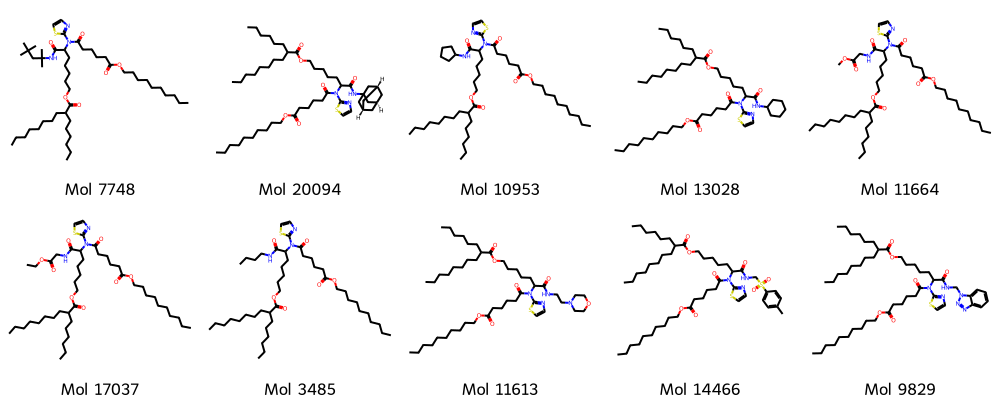

In [21]:
print("Least 10 predicted smiles: ")
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in combined_df["SMILES"].values[-10:]], molsPerRow=5, legends=[f"Mol {id}" for id in combined_df_sort["SMILES"].index[-10:]])
display(img)

## Converting back to component names

In [22]:
ref_path = '/h/pangkuan/dev/SDL-LNP/model/data_process/220k_library.csv'

ref_df = pd.read_csv(ref_path)

ref_df

,id,combined_mol_SMILES,A_smiles,B_smiles,C_smiles,D_smiles
0,0,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CC12C[C@H]3C[C@@...,NCCN(C)C,C[N+]#[C-],CCCCCC=O,OC(CC(C1)(C2)C[C@@H]3C[C@H]2C[C@H]1C3)=O
1,1,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)C[C@@]12C[C@@H]3...,NCCN(C)C,C[N+]#[C-],CCCCCC=O,OC(C[C@@](C1)(C2)C[C@]3(O)C[C@H]2C[C@H]1C3)=O
2,2,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CCN1CCCCC1,NCCN(C)C,C[N+]#[C-],CCCCCC=O,OC(CCN1CCCCC1)=O
3,3,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CN(C)C,NCCN(C)C,C[N+]#[C-],CCCCCC=O,CN(CC(O)=O)C
4,4,CCCCCC(C(=O)NC)N(CCN(C)C)C(=O)CCN(C)C,NCCN(C)C,C[N+]#[C-],CCCCCC=O,CN(CCC(O)=O)C
...,...,...,...,...,...,...
221179,221179,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,CCCCCCCCC(OC(CCCCC(O)=O)=O)CCCCCCCC
221180,221180,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,CCC(CCC(OC(CCCCC(O)=O)=O)CC(C)C)CCCC
221181,221181,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,OC(CCCCC(OCCCCCCCCCC)=O)=O
221182,221182,CCCCC/C=C\C/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@...,NCCCN1CCCCCC1,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCC/C=C\C/C=C\CCCCCCCC=O,OC(CCCCC(OCCCCCCCCCCC)=O)=O


In [23]:
component_smiles_path = "/h/pangkuan/dev/SDL-LNP/Chem_Doc/SMILES_96_4CR.csv"

component_smiles_df = pd.read_csv(component_smiles_path)

component_smiles_df

,ID,Name,SMILES
0,A1,D5616,NCCN(C)C
1,A2,A2241,NN1CCCCC1
2,A3,A0409,NCCCN1CCOCC1
3,A4,A0304,NCCN1CCNCC1
4,A5,D0790,NCCCN(C)C
...,...,...,...
91,D32,H1401+A0161,CCCCCCCCC(OC(CCCCC(O)=O)=O)CCCCCCCC
92,D33,E0144+A0161,CCC(CCC(OC(CCCCC(O)=O)=O)CC(C)C)CCCC
93,D34,D0031+A0161,OC(CCCCC(OCCCCCCCCCC)=O)=O
94,D35,U0005+A0161,OC(CCCCC(OCCCCCCCCCCC)=O)=O


In [24]:
combined_df_sort["SMILES"].values[:30]

array(['CCCCCCCCCCCOC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCC)CCCCCC)C(=O)NC1CCCCC1',
       'CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1',
       'CCCCCCCCCCCCCCCC(C(=O)NC1CCCCC1)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC',
       'CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCC)CCCCCC)C(=O)NC1CCCCC1',
       'CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCCCC)CCCCCCCC)C(=O)NC1CCCCC1',
       'CCCCC/C=C\\C/C=C\\CCCCCCCC(C(=O)NCn1nnc2ccccc21)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC',
       'CCCCC/C=C\\C/C=C\\CCCCCCCC(C(=O)NCn1nnc2ccccc21)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OCC(CCCCCC)CCCCCCCC',
       'CCCCCCCCCCCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](C1)C[C@@H](C2)C3)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCC(CC)CCCC)CC(C)C',
       'CCCCCCCCCCCC(C(=O)NC(C)(C)CC(C)(C)C)N(CCCN(C)CCCN)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC',
       'CCCCCCC(CCC)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCCCOC(=O)C(CCCC)CCCCCC)C(=O)NC1CCCCC1',
 

In [25]:
# mapped_df
# sorted top 96 smiles, pred, a_name, b_name, c_name, d_name, a_smiles, b_smiles, c_smiles, d_smiles

mapped_df = pd.DataFrame(columns=["SMILES", "predict", "a_name", "b_name", "c_name", "d_name", "a_smiles", "b_smiles", "c_smiles", "d_smiles"])

NUM = 96
for smi in combined_df_sort["SMILES"].values[:NUM]:
    idx = combined_df_sort[combined_df_sort["SMILES"] == smi].index[0]
    a_name, b_name, c_name, d_name = None, None, None, None
    a_smiles, b_smiles, c_smiles, d_smiles = None, None, None, None
    row = ref_df[ref_df["combined_mol_SMILES"] == smi]
    a_smiles = row["A_smiles"].values[0]
    b_smiles = row["B_smiles"].values[0]
    c_smiles = row["C_smiles"].values[0]
    d_smiles = row["D_smiles"].values[0]
    a_name = component_smiles_df[component_smiles_df["SMILES"] == a_smiles]["Name"].values[0]
    b_name = component_smiles_df[component_smiles_df["SMILES"] == b_smiles]["Name"].values[0]
    c_name = component_smiles_df[component_smiles_df["SMILES"] == c_smiles]["Name"].values[0]
    d_name = component_smiles_df[component_smiles_df["SMILES"] == d_smiles]["Name"].values[0]
    mapped_df = mapped_df.append({"idx": int(idx),
                                    "SMILES": smi, 
                                  "predict": combined_df_sort[combined_df_sort["SMILES"] == smi]["predict"].values[0], 
                                  "a_name": a_name, "b_name": b_name, "c_name": c_name, "d_name": d_name, 
                                  "a_smiles": a_smiles, "b_smiles": b_smiles, "c_smiles": c_smiles, "d_smiles": d_smiles}, 
                                 ignore_index=True)
mapped_df

,SMILES,predict,a_name,b_name,c_name,d_name,a_smiles,b_smiles,c_smiles,d_smiles,idx
0,CCCCCCCCCCCOC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCCC...,0.473810,B0821,C1438,2-hexyldecanoic acid,U0005+A0161,NCCCN(C)CCCN,[C-]#[N+]C1CCCCC1,CCCCCCC(CCCC)C(OCCCCCC=O)=O,OC(CCCCC(OCCCCCCCCCCC)=O)=O,21488.0
1,CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)N(CCCN(C)CCC...,0.471724,B0821,C1438,2-butyloctanoic acid,H1401+A0161,NCCCN(C)CCCN,[C-]#[N+]C1CCCCC1,O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O,CCCCCCCCC(OC(CCCCC(O)=O)=O)CCCCCCCC,12583.0
2,CCCCCCCCCCCCCCCC(C(=O)NC1CCCCC1)N(CCCN(C)CCCN)...,0.471103,B0821,C1438,H0071,H1401+A0161,NCCCN(C)CCCN,[C-]#[N+]C1CCCCC1,CCCCCCCCCCCCCCCC=O,CCCCCCCCC(OC(CCCCC(O)=O)=O)CCCCCCCC,18077.0
3,CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CC...,0.469105,B0821,C1438,2-hexyldecanoic acid,U0027+A0161,NCCCN(C)CCCN,[C-]#[N+]C1CCCCC1,CCCCCCC(CCCC)C(OCCCCCC=O)=O,OC(CCCCC(OC(C)CCCCCCCCC)=O)=O,13978.0
4,CCCCCCCCCC(C)OC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CC...,0.467707,B0821,C1438,2-butyloctanoic acid,U0027+A0161,NCCCN(C)CCCN,[C-]#[N+]C1CCCCC1,O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O,OC(CCCCC(OC(C)CCCCCCCCC)=O)=O,13990.0
...,...,...,...,...,...,...,...,...,...,...,...
91,CCCCCCCCC(CCCCCC)C(C(=O)NCn1nnc2ccccc21)N(CCCN...,0.445557,B0821,I0455,H1461,E0144+A0161,NCCCN(C)CCCN,[C-]#[N+]CN1C(C=CC=C2)=C2N=N1,CCCCCCCCC(CCCCCC)C=O,CCC(CCC(OC(CCCCC(O)=O)=O)CC(C)C)CCCC,12194.0
92,CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CCN1CCCC1)C(CCCC...,0.445490,A0884,T1046,2-hexyldecanoic acid,L0124,NCCN1CCCC1,O=S(C[N+]#[C-])(C1=CC=C(C)C=C1)=O,CCCCCCC(CCCC)C(OCCCCCC=O)=O,CCCCC/C=C\C/C=C\CCCCCCCC(O)=O,3691.0
93,CCCCCCCCCCCCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](C1)...,0.445468,B0821,I0824,O0006,U0005+A0161,NCCCN(C)CCCN,[C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1,CCCCCCCCCCCCCCCCCC=O,OC(CCCCC(OCCCCCCCCCCC)=O)=O,20587.0
94,C=CCCCCCCCCCOC(=O)CCCCC(=O)N(CCCN(C)CCCN)C(CCC...,0.445357,B0821,C1438,H0018,U0047+A0161,NCCCN(C)CCCN,[C-]#[N+]C1CCCCC1,CCCCCCCCCCCCCCCCC=O,OC(CCCCC(OCCCCCCCCCC=C)=O)=O,2665.0


In [26]:
mapped_df.to_csv("/scratch/ssd004/datasets/cellxgene/unimol_pred/pred1920/component_mapped.csv", index=False)